In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Activation, Input, UpSampling2D, BatchNormalization, PReLU, Add, Lambda, LeakyReLU, Flatten
from tensorflow.keras import optimizers, losses, metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import vgg19



# SRGAN or ESRGAN

In [2]:
#################
# Load Image
################
'''
사용한 이미지는 고해상도 및 저해상도 각 100장씩으로 쌍을 이루고 있으며, 캐글 Super Resolution 데이터 셋을 사용.
저해상도 이미지는 입력 데이터로 사용되며, 모델을 거쳐 나온 이미지는 고해상도 이미지와 loss를 계산해 학습하는 방식을 거침.

#SRGAN 모델 순서
.

#SRGAN 테스트 결과
.
'''
HR_dir = './Data/HR/' # 고해상도 디렉토리 
LR_dir = './Data/LR' # 저해상도 디렉토리

def load_img(directory):
    img = []
    for img_dir in glob.glob(directory+str('/*')):
        tmp = plt.imread(img_dir)
#         tmp = cv2.resize(tmp,dsize=(384,384), interpolation=cv2.INTER_CUBIC)
        img.append(tmp)
    img = np.array(img)
    return img
HR_img = load_img(HR_dir)
LR_img = load_img(LR_dir)

print(f'HR Shape : {HR_img.shape}')
print(f'LR Shape : {LR_img.shape}')
#예시는 아래 참조

HR Shape : (100, 384, 384, 3)
LR Shape : (100, 96, 96, 3)


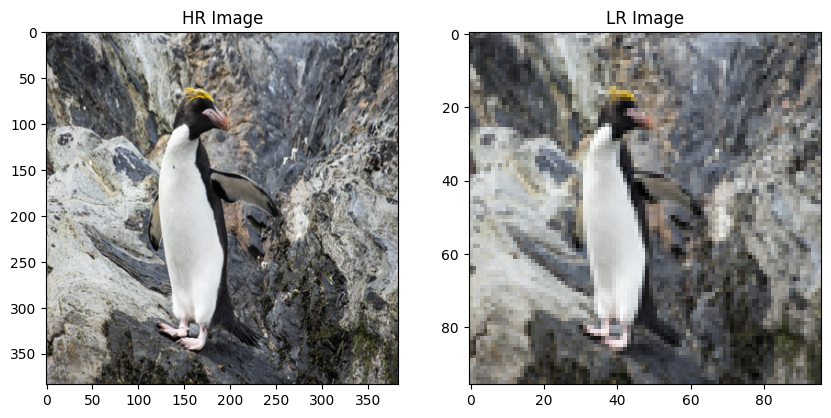

In [3]:
'''
예시 사진
'''
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(HR_img[0])
plt.title("HR Image")
plt.subplot(1,2,2)
plt.imshow(LR_img[0])
plt.title('LR Image')
plt.show()

In [16]:
#################
# Train / Test
################
HR_train, HR_val, LR_train, LR_val = train_test_split(HR_img, LR_img, test_size=0.1)

In [50]:
HR_train.shape

(90, 384, 384, 3)

# Generator  
  
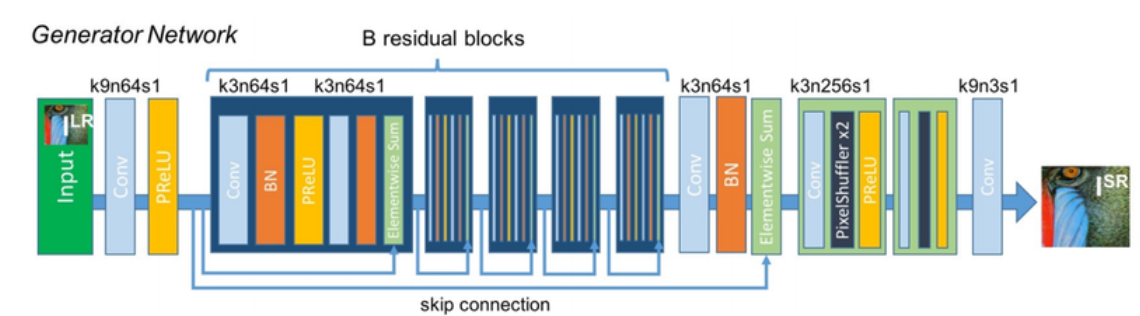

### 이해 안가는 부분
PReLU의 shared_axes=[1,2] 옵션이 의미하는 바

In [24]:
#################
# Build Generator
################

'''
Generator
'''

def residual_block(x):
    out = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
    out = BatchNormalization()(out)
    out = PReLU(shared_axes=[1,2])(out)
    out = Conv2D(64, 3, 1, 'same')(out)
    out = BatchNormalization()(out)
    return Add()([x, out])

def upsample_block(x):
    out = Conv2D(256, 3, 1, 'same')(x)
    out = Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return PReLU(shared_axes=[1,2])(out)

def Generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = Conv2D(64, 9, 1, 'same')(inputs)
    out = residual = PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = residual_block(out)
        
    out = Conv2D(64, 3, 1, 'same')(out)
    out = BatchNormalization()(out)
    out = Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = Conv2D(3, 9, 1, 'same', activation='tanh')(out)
    return Model(inputs, out)




# Discriminator    
  
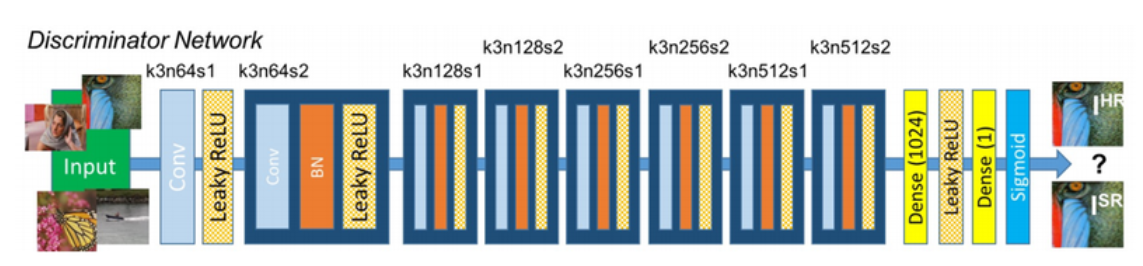

In [19]:
######################
# Build Discriminator
#####################
'''
Discriminator
'''   

def discriminator_block(x, n_filters):
    out = Conv2D(n_filters, 3, 1, 'same')(x)
    out = BatchNormalization()(out)
    out = LeakyReLU()(out)
    out = Conv2D(n_filters, 3, 2, 'same')(out)
    out = BatchNormalization()(out)
    return LeakyReLU()(out)

def Discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = Conv2D(64, 3, 1, 'same')(inputs)
    out = LeakyReLU()(out)
    out = Conv2D(64, 3, 2, 'same')(out)
    out = BatchNormalization()(out)
    out = LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = discriminator_block(out, n_filters)
        
    #out = Flatten()(out)
    
    out = Dense(1024)(out)
    out = LeakyReLU()(out)
    out = Dense(1, activation='sigmoid')(out)
    return Model(inputs, out)

In [21]:
def feature_extract(innput_shape=(None, None, 3)):
    vgg = vgg19.VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=(None,None,3))
    return Model(vgg.input, vgg.layers[20].output)

In [55]:
generator = Generator((96,96,3))
discriminator = Discriminator((384,384,3))
vgg = feature_extract()

########################
# Define Loss&Optimizer
#######################
'''
Loss & Optimizer
predict 값이 [0,1]일 경우 from_logits=False / [-inf,inf]일 경우 normalize하기 위해서 from_logits=True 사용 -> 마지막 layer에 sigmoid 또는 softmax 사용했을 경우 False, activation function 사용하지 않은 경우 True
* tanh일 경우엔?
'''
bce = losses.BinaryCrossentropy(from_logits=True) # Default from_logits=False
mse = losses.MeanSquaredError()
generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

'''
generator는 진짜 같은 이미지 생성이 목적이므로 가짜 이미지가 0이 아닌 1로 판별하도록 loss 계산
'''
def generator_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

'''
discriminator는 진짜 이미지는 1, 가짜 이미지는 0으로 판별하는 것이 목적이므로, 목적에 맞는 loss 계산
'''
def discriminator_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)

@tf.function
def content_loss(hr, sr):
    hr = vgg19.preprocess_input(hr)
    sr = vgg19.preprocess_input(sr)
    
    hr_feature = vgg(hr) / 12.75
    sr_feature = vgg(sr) / 12.75
    return mse(hr_feature, sr_feature)

@tf.function
def train_step(lr, hr):
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        
        # Forward pass
        sr = generator(lr, training=True)
        hr_output = discriminator(hr, training=True)
        sr_output = discriminator(sr, training=True)
        
        # Compute losses
        con_loss = content_loss(hr, sr)                           # Content Loss
        gen_loss = generator_loss(sr_output)                      # Generator Loss
        perc_loss = con_loss + 1e-3*gen_loss                     # Perceptual Loss
        disc_loss = discriminator_loss(hr_output, sr_output)     # Discriminator Loss
        
        # Compute gradient of perceptual loss (generator weights)
        gradients_generator = generator_tape.gradient(perc_loss, generator.trainable_variables)
        # Compute gradient of discriminator loss (discriminator weights)
        gradients_discriminator = discriminator_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # Update weights (Generator & Discriminator)
        generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_discriminator, discriminator.trainable_variables))
        
    return perc_loss, disc_loss


In [27]:
import os
###############
# Save Weights
##############

def save_weights(generator, epoch):
    directory = "./"
    if not os.path.exists(directory):
        os.mkdir(directory)
    path = os.path.join(directory, f"generator_{epoch+1}.hdf5")
    generator.save(path)

In [31]:
import time

In [56]:
#########
# Train
########

gen_losses = metrics.Mean()
dis_losses = metrics.Mean()

def train(lr, hr, epochs):
    for epoch in range(epochs):
        start = time.time()
        for i, (lr, hr) in enumerate(zip(lr, hr)):
            perc_loss, disc_loss = train_step(lr, hr)
            gen_losses.update_state(perc_loss)
            dis_losses.update_state(disc_loss)
        print("Epoch: [{}/{}] step: Perceptual.loss: {:.3f}: Discriminator.loss: {:.3f} [{} sec]".format(epoch+1, epochs+1 , perc_loss, disc_loss, time.time()-start))
        gen_losses.reset_states()
        dis_losses.reset_states()
        save_weights(generator, epoch)

# train(LR_train, HR_train, epochs=200)
# WARNING:tensorflow:Model was constructed with shape (None, 96, 96, 3) for input Tensor("input_9:0", shape=(None, 96, 96, 3), dtype=float32), but it was called on an input with incompatible shape (96, 96, 3).

In [51]:
train(LR_train, HR_train, epochs=200)

ValueError: in user code:

    C:\Users\pc\AppData\Local\Temp\ipykernel_10324\592236511.py:44 train_step  *
        sr = generator(lr, training=True)
    C:\Users\pc\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\pc\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\pc\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\pc\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\pc\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer conv2d_65 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [96, 96, 3]


# 현재 참고 작성 중인 사이트
https://www.kaggle.com/code/muhammadhananasghar/srgan-implementation-in-keras  
https://panggu15.github.io/gan/SRGAN/  


https://www.kaggle.com/code/akhileshdkapse/sr-super-resolution-gan-keras  
https://rueki.tistory.com/231  